In [23]:
!pip install joblib
!pip install faiss-cpu

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# Load Data

In [24]:
from google.colab import drive
drive.mount('/content/drive')
print("Loading datasets...")
# Ensure these match your uploaded filenames exactly
train = pd.read_csv('/content/drive/MyDrive/MLProject/data/recommended/training/training_cleaned.csv')
test = pd.read_csv('/content/drive/MyDrive/MLProject/data/recommended/test/test_cleaned.csv')
print("Train shape:", train.shape)
print("Test shape: ", test.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading datasets...
Train shape: (2934817, 14)
Test shape:  (733705, 14)


# Pre-Processing

In [25]:
# Drop unnamed index columns if they exist
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

# Replace missing numeric values with median
num_cols = train.select_dtypes(include=[np.number]).columns
for col in num_cols:
    median_val = train[col].median()
    train[col].fillna(median_val, inplace=True)
    test[col].fillna(median_val, inplace=True)

# Replace missing categorical values with mode
cat_cols = train.select_dtypes(include=['object']).columns
for col in cat_cols:
    mode_val = train[col].mode()[0]
    train[col].fillna(mode_val, inplace=True)
    test[col].fillna(mode_val, inplace=True)

# Separate target
y_train = train["category"]
y_test  = test["category"]

# Drop target
train_features = train.drop(["category"], axis=1)
test_features  = test.drop(["category"], axis=1)

# One-hot encode
train_encoded = pd.get_dummies(train_features)
test_encoded  = pd.get_dummies(test_features)
print(train_encoded.shape, test_encoded.shape)

# Align test columns to training
train_encoded, test_encoded = train_encoded.align(test_encoded, join="left", axis=1, fill_value=0)
print(train_encoded.shape, test_encoded.shape)

# Sample 200k rows from the training set
sample_indices = train_encoded.sample(500_000, random_state=42).index

X_train_sampled = train_encoded.loc[sample_indices]
y_train_sampled = y_train.loc[sample_indices]

# Scale on sampled set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_test_scaled  = scaler.transform(test_encoded)

from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Keep top 12 most informative features (adjust number as needed)
selector = SelectKBest(score_func=mutual_info_classif, k=12)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_sampled)
X_test_selected  = selector.transform(X_test_scaled)


/tmp/ipython-input-2623245952.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(median_val, inplace=True)
/tmp/ipython-input-2623245952.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

(2934817, 17) (733705, 17)
(2934817, 17) (733705, 17)


# Train KNN

In [26]:
# knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)
# knn.fit(X_train_scaled, y_train_sampled)

# y_pred = knn.predict(X_test_scaled)


# Approximate Nearest Neighbors (better for large datasets)

In [28]:
# --- Step 2: Approximate KNN using FAISS ---
import faiss

# Convert to float32 for FAISS
X_train_f = X_train_selected.astype('float32')
X_test_f  = X_test_selected.astype('float32')

# Create FAISS index for Euclidean distance
index = faiss.IndexFlatL2(X_train_f.shape[1])
index.add(X_train_f)

# Search for k nearest neighbors
k = 5  # same as n_neighbors
distances, indices = index.search(X_test_f, k)

# Predict labels by majority vote among neighbors
import numpy as np
y_pred = np.array([y_train_sampled.iloc[idx].mode()[0] for idx in indices])

# Evaluation

Accuracy: 0.9988251408945013
F1 Score: 0.9988317487802992

Classification Report:
                                precision    recall  f1-score   support

                     DDoS TCP       1.00      1.00      1.00    195355
                     DDoS UDP       1.00      1.00      1.00    189954
                      DoS TCP       1.00      1.00      1.00    123486
                      DoS UDP       1.00      1.00      1.00    206626
                       Normal       0.84      0.83      0.84       107
Reconnaissance OS_Fingerprint       0.87      0.91      0.89      3621
  Reconnaissance Service_Scan       0.98      0.97      0.97     14542
                        Theft       0.89      0.57      0.70        14

                     accuracy                           1.00    733705
                    macro avg       0.95      0.91      0.92    733705
                 weighted avg       1.00      1.00      1.00    733705



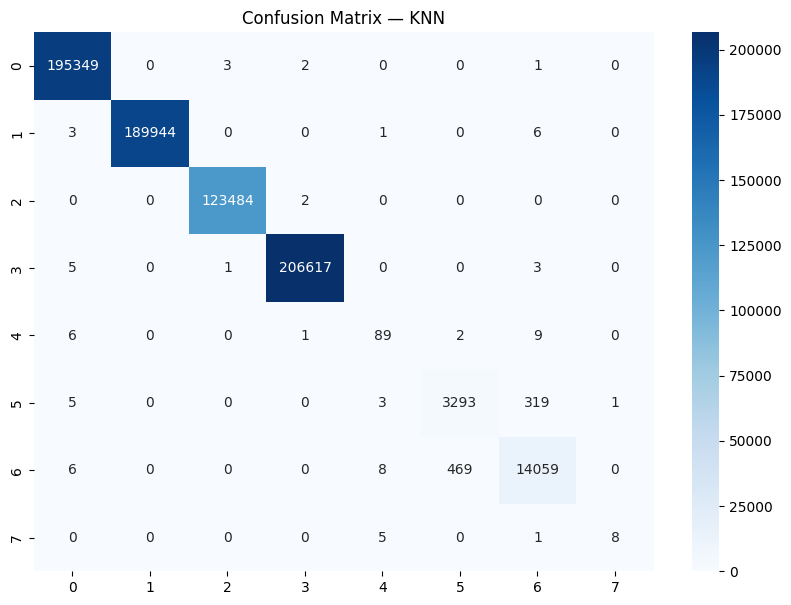

In [29]:
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", acc)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — KNN")
plt.show()


# GridSearchCV

In [30]:
param_grid = {
    "n_neighbors": [3,5,7,9],
    "weights": ["distance", "uniform"],
    "p": [1, 2]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring="f1_weighted",
    n_jobs=-1,
    cv=cv,
    verbose=2
)

grid.fit(X_train_selected, y_train_sampled)

print("Best params according to GridSearchCV:", grid.best_params_)
print("Best F1-score according to GridSearchCV:", grid.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params according to GridSearchCV: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best F1-score according to GridSearchCV: 0.9990371802203621


# RandomizedSearchCV (best one)



In [31]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# --- Step 1: Define hyperparameter distribution ---
param_dist = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

# --- Step 2: Cross-validation strategy ---
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Step 3: Create RandomizedSearchCV ---
grid = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=param_dist,
    n_iter=20,                  # 20 random combinations
    scoring="f1_weighted",
    n_jobs=-1,                  # use all CPUs
    cv=cv,
    verbose=2,
    random_state=42
)

# --- Step 4: Fit on scaled sampled training data ---
grid.fit(X_train_selected, y_train_sampled)

# --- Step 5: Best hyperparameters & performance ---
print("Best params according to RandomizedSearchCV:", grid.best_params_)
print("Best F1-score according to RandomizedSearchCV:", grid.best_score_)

# --- Step 6: Train final KNN on the sampled training set ---
best_knn = grid.best_estimator_
best_knn.fit(X_train_selected, y_train_sampled)

# --- Step 7: Predict on scaled test set ---
y_pred = best_knn.predict(X_test_selected)

# --- Step 8: Evaluate performance ---
from sklearn.metrics import accuracy_score, f1_score, classification_report

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", acc)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params according to RandomizedSearchCV: {'weights': 'distance', 'p': 1, 'n_neighbors': 5}
Best F1-score according to RandomizedSearchCV: 0.9990371802203621
Accuracy: 0.9992094915531446
F1 Score: 0.9992136523871811

Classification Report:
                                precision    recall  f1-score   support

                     DDoS TCP       1.00      1.00      1.00    195355
                     DDoS UDP       1.00      1.00      1.00    189954
                      DoS TCP       1.00      1.00      1.00    123486
                      DoS UDP       1.00      1.00      1.00    206626
                       Normal       0.93      0.94      0.94       107
Reconnaissance OS_Fingerprint       0.91      0.94      0.93      3621
  Reconnaissance Service_Scan       0.98      0.98      0.98     14542
                        Theft       0.87      0.93      0.90        14

                     accuracy                         

# Save Joblib

In [34]:
best_knn = grid.best_estimator_
best_knn.fit(X_train_selected, y_train_sampled)

# Save
joblib.dump(best_knn, "/content/drive/MyDrive/knn_attack_classifier.joblib")

print("Model saved successfully!")


Model saved successfully!
